# [Time Series Analysis in Python](https://www.datacamp.com/completed/statement-of-accomplishment/course/6e0780bfcb1de82469823086a1d4e272e8e25727)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/datacamp/blob/main/notebooks/courses/time_series_analysis_in_python/notebook.ipynb)
[![Render nbviewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/datacamp/blob/main/notebooks/courses/time_series_analysis_in_python/notebook.ipynb)

**Contents**
- [Correlation and Autocorrelation](#Correlation-and-Autocorrelation)
- [Simple Models](#Simple-Models)
- [Autoregressive Models](#Autoregressive-Models)
- [Moving Average Models](#Moving-Average-Models)
- [Cointegration Models](#Cointegration-Models)


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict

# fmt: off
amzn = pd.read_csv("amzn.csv", parse_dates=["Date"], index_col="Date")
bonds = pd.read_csv("bonds.csv", parse_dates=["observation_date"], index_col="observation_date")
btc = pd.read_csv("btc.csv", parse_dates=["Date"], index_col="Date")
daily_rates = pd.read_csv("daily_rates.csv", parse_dates=["DATE"], index_col="DATE")
diet = pd.read_csv("diet.csv", parse_dates=["Date"], index_col="Date")
eth = pd.read_csv("eth.csv", parse_dates=["Date"], index_col="Date")
hrb = pd.read_csv("hrb.csv", parse_dates=["Quarter"], index_col="Quarter")
levels = pd.read_csv("levels.csv", parse_dates=["Date"], index_col="Date")
msft = pd.read_csv("msft.csv", parse_dates=["Date"], index_col="Date")
stocks = pd.read_csv("stocks.csv", parse_dates=["observation_date"], index_col="observation_date")
# fmt: on


## Correlation and Autocorrelation

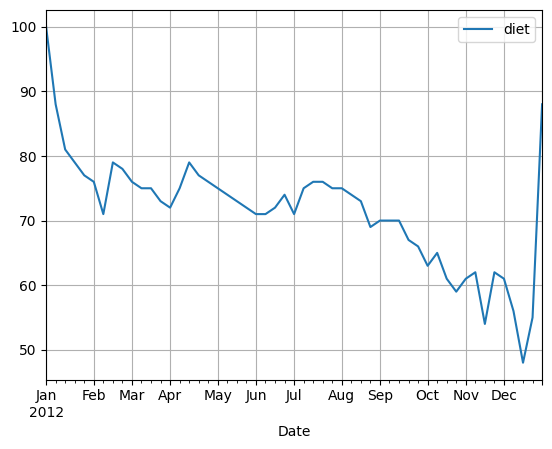

In [2]:
# plot only 2012 data
diet.loc["2012"].plot(grid=True)
plt.show()


### Correlation

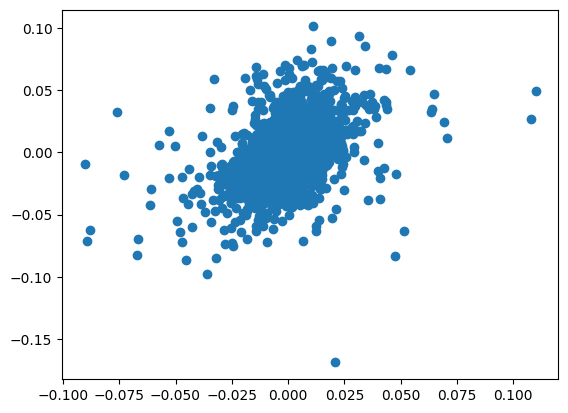

In [3]:
stocks_and_bonds = stocks.join(bonds, how="inner")
returns = stocks_and_bonds.pct_change()
correlation = returns["SP500"].corr(returns["US10Y"])
plt.scatter(returns["SP500"], returns["US10Y"])
plt.show()


In [4]:
correlation1 = levels["DJI"].corr(levels["UFO"])
changes = levels.pct_change()
correlation2 = changes["DJI"].corr(changes["UFO"])

print("Correlation of levels: ", correlation1)
print("Correlation of changes: ", correlation2)


Correlation of levels:  0.9399762210726432
Correlation of changes:  0.06026935462405376


### Autocorrelation

In [5]:
msft = msft.resample("W").last()
returns = msft.pct_change()
autocorrelation = returns["Adj Close"].autocorr()
print(f"The autocorrelation of weekly returns is {autocorrelation:4.2f}")


The autocorrelation of weekly returns is -0.16


In [6]:
daily_diff = daily_rates.diff()
autocorrelation_daily = daily_diff["US10Y"].autocorr()
print(f"The autocorrelation of daily interest rate changes is {autocorrelation_daily:4.2f}")

yearly_rates = daily_rates.resample("A").last()
yearly_diff = yearly_rates.diff()
autocorrelation_yearly = yearly_diff["US10Y"].autocorr()
print(f"The autocorrelation of annual interest rate changes is {autocorrelation_yearly:4.2f}")


The autocorrelation of daily interest rate changes is 0.07
The autocorrelation of annual interest rate changes is -0.22


## Simple Models

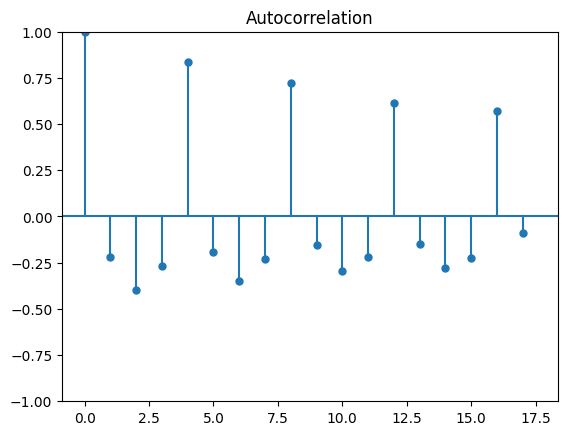

In [7]:
plot_acf(hrb, alpha=1)
plt.show()


In [8]:
# resample msft to weekly
msft_weekly = msft.resample("W").last()
returns_weekly = msft_weekly.dropna().pct_change().round(3)

# autocorrelation of "Adj Close"
autocorrelation = returns_weekly["Adj Close"].autocorr()
print(f"The autocorrelation of weekly MSFT returns is {autocorrelation:4.2f}")

# number of observations and confidence level
nobs = len(returns_weekly)
conf = 1.96 / sqrt(nobs)
print(f"The approximate confidence interval is +/- {conf:4.2f}")


The autocorrelation of weekly MSFT returns is -0.16
The approximate confidence interval is +/- 0.12


### White Noise

_White noise_ is a series with a constant mean, constant variance, and no autocorrelation at any lag. If the data has a normal distribution, then it is _Gaussian white noise_.

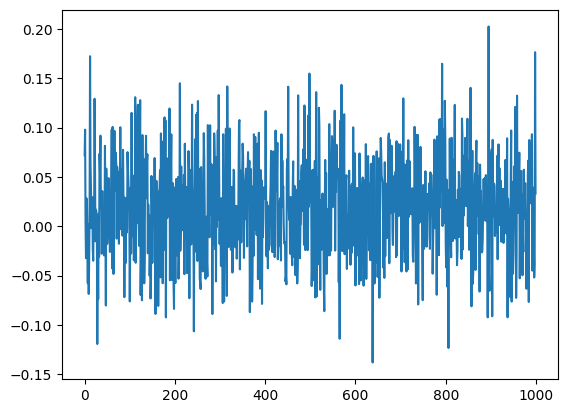

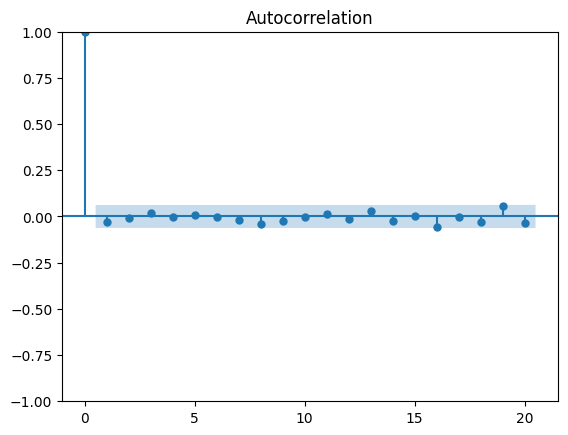

In [9]:
returns = np.random.normal(loc=0.02, scale=0.05, size=1000)
mean = np.mean(returns)
std = np.std(returns)
plt.plot(returns)
plt.show()
plot_acf(returns, lags=20)
plt.show()


### Random Walk

While stock _returns_ are often modeled as white noise, stock _prices_ closely follow a _random walk_. In other words, today's price is yesterday's price plus some random noise.

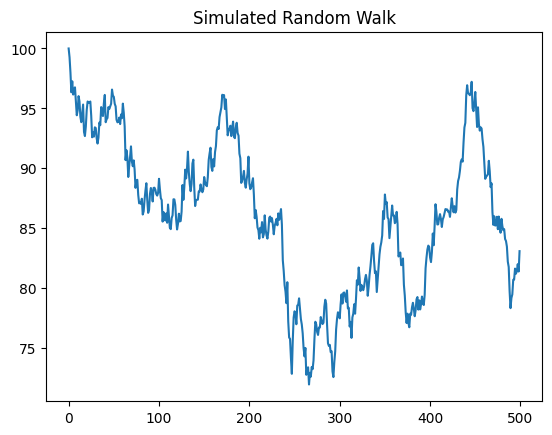

In [10]:
# 500 random steps with mean=0 and std=1
steps = np.random.normal(loc=0, scale=1, size=500)

# set first element to zero (first price is starting price)
steps[0] = 0

# simulate P stock prices with a starting price of 100 and plot
P = 100 + np.cumsum(steps)
plt.plot(P)
plt.title("Simulated Random Walk")
plt.show()


### Drift

In many random processes, there is a tendency for the values to revert back to the long-term average (mean reversion). A random walk with drift does not revert to the mean, instead it _drifts_ away.

Some time series, like stock prices, can trend up or down over time. This is the drift, represented by $\mu$ (mu). If positive, the random walk has an upward trend and vice-versa if negative.

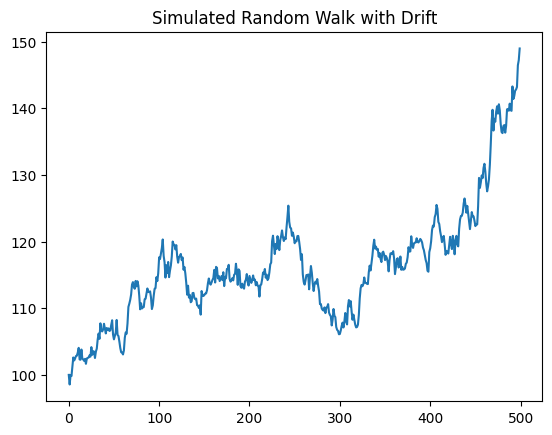

In [11]:
# 500 random steps with mean=0.001 and std=0.01
steps = np.random.normal(loc=0.001, scale=0.01, size=500) + 1

# set first element to 1
steps[0] = 1

# simulate P by taking the cumulative product and plot
P = 100 * np.cumprod(steps)
plt.plot(P)
plt.title("Simulated Random Walk with Drift")
plt.show()


### Augmented Dickey-Fuller Test

The _Augmented Dickey-Fuller Test_ (ADF) tests the null hypothesis that a _unit root_ is present in a time series sample. A unit root is a feature of some stochastic (random) processes. If a time series has a unit root, it means that the past values of the series influence the current value. It is like a boat without an anchor, drifting with the tide (not stationary). Whereas if it doesn't have a unit root, it is more like an anchored boat, moving around a little but generally staying in the same place (mean reversion).

In [12]:
results = adfuller(amzn["Adj Close"])
print(
    f"The p-value from the ADF test is {results[1]:4.2f}"
)  # large p-value, unit root present (data is not stationary)


The p-value from the ADF test is 1.00


In [13]:
amzn_returns = amzn.pct_change().dropna()
results = adfuller(amzn_returns["Adj Close"])
print(
    f"The p-value from the ADF test is {results[1]:4.2f}"
)  # tiny p-value, no unit root (returns are stationary)


The p-value from the ADF test is 0.00


### Stationarity

A time series is _stationary_ if its statistical properties do not change over time. In other words, it has constant mean, variance, and autocorrelation. The temperatures in a region with a stable climate are stationary, whereas the temperatures in Massachusetts are highly-seasonal and therefore not stationary. Stock market prices tend to drift, so they are not stationary.


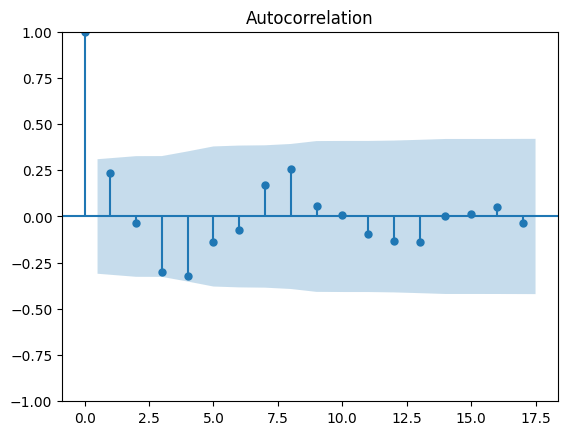

In [14]:
# seasonally adjust HR Block quarterly earnings
hrb_sa = hrb.diff(4).dropna()

# plot
plot_acf(hrb_sa)
plt.show()


## Autoregressive Models

_Autoregressive_ refers to a model where the current value in a series depends on the previous values. The notation for an autoregressive model specifies the order of the model, for example AR(1) is a first-order autoregressive model. This means the current value depends on the previous value, AR(2) means the current value depends on the two previous values, and so on. This can be expressed mathematically as:

$X_t = \mu + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \cdots + \phi_p X_{t-p} + \epsilon_t$

where $\mu$ is the mean of the series, $\phi_1$ is the lag-1 coefficient, $\phi_2$ is the lag-2 coefficient, and so on. The $\epsilon_t$ is the error term or residual.

Ideally, the residual (difference between the model and the data) should be random (white noise). If the residuals show a pattern, it means the model is missing some information.

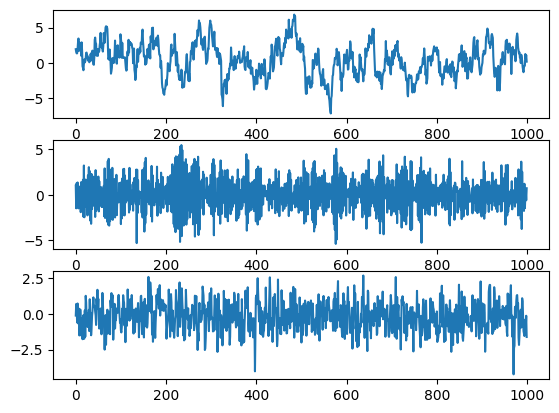

In [15]:
# phi of +0.9
plt.subplot(3, 1, 1)
ar1 = np.array([1, -0.9])  # use -0.9 for a +0.9 phi (convention)
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# phi of -0.9
plt.subplot(3, 1, 2)
ar2 = np.array([1, 0.9])  # use +0.9 for a -0.9 phi
ma2 = np.array([1])
AR_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = AR_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)

# phi of +0.3
plt.subplot(3, 1, 3)
ar3 = np.array([1, -0.3])
ma3 = np.array([1])
AR_object3 = ArmaProcess(ar3, ma3)
simulated_data_3 = AR_object3.generate_sample(nsample=1000)
plt.plot(simulated_data_3)
plt.show()


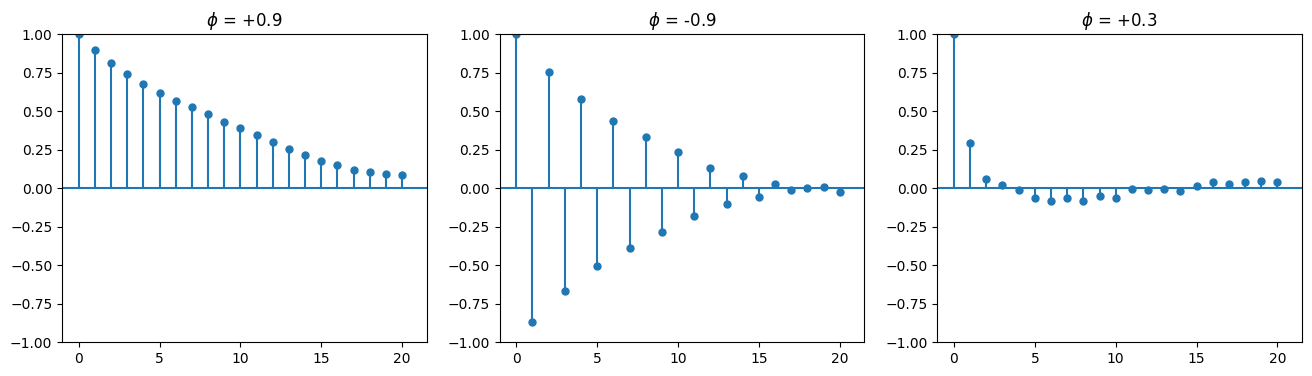

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

plot_acf(simulated_data_1, ax=axes[0], alpha=1, lags=20, title="$\phi$ = +0.9")
plot_acf(simulated_data_2, ax=axes[1], alpha=1, lags=20, title="$\phi$ = -0.9")
plot_acf(simulated_data_3, ax=axes[2], alpha=1, lags=20, title="$\phi$ = +0.3")

plt.show()


In [17]:
# fit an AR(1) model to `simulated_data_1`
model = ARIMA(simulated_data_1, order=(1, 0, 0))
results = model.fit()
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1421.113
Date:                Wed, 22 Nov 2023   AIC                           2848.226
Time:                        12:33:55   BIC                           2862.950
Sample:                             0   HQIC                          2853.822
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4249      0.304      1.396      0.163      -0.172       1.021
ar.L1          0.8963      0.014     62.004      0.000       0.868       0.925
sigma2         1.0027      0.040     25.368      0.0

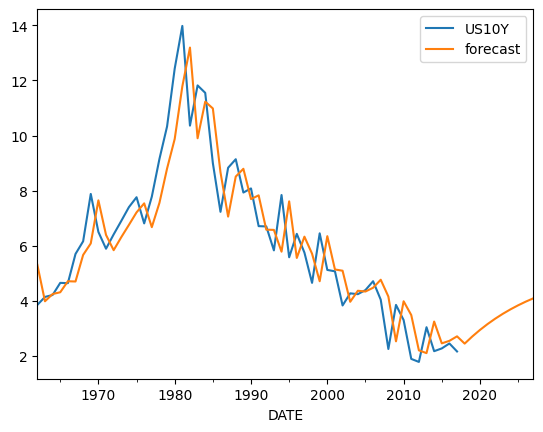

In [18]:
# convert `daily_rates` to annual (last day of year)
annual_rates = daily_rates.resample("A").last()

# convert to series
annual_rates = annual_rates.squeeze()

# fit an AR(1) model to the data
model = ARIMA(annual_rates, order=(1, 0, 0))
results = model.fit()

# plot
fig, ax = plt.subplots()
annual_rates.plot(ax=ax)
plot_predict(results, start=0, end="2027", alpha=None, ax=ax)
plt.show()


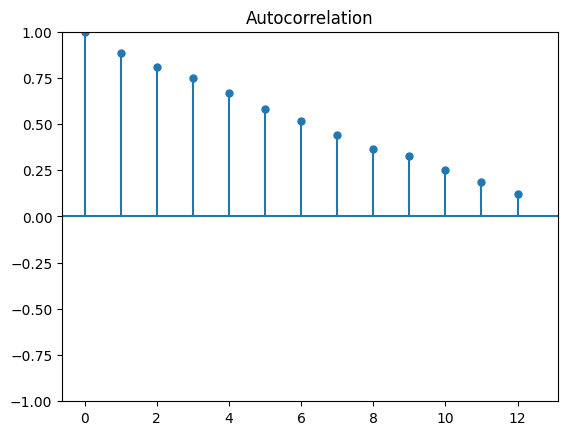

In [19]:
# plot autocorrelation function of annual rates
plot_acf(annual_rates, lags=12, alpha=1)
plt.show()


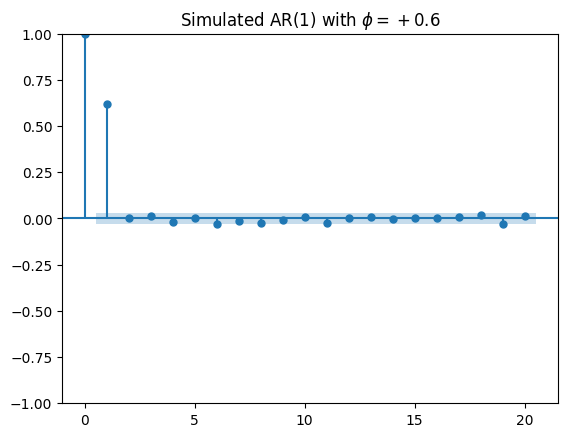

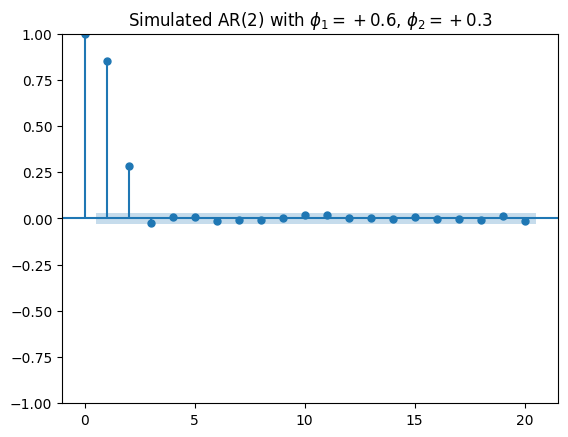

In [20]:
# simulate AR(1) with phi=+0.6
ma = np.array([1])
ar = np.array([1, -0.6])
AR_object = ArmaProcess(ar, ma)
simulated_data_1 = AR_object.generate_sample(nsample=5000)

# plot PACF
plot_pacf(simulated_data_1, lags=20, title="Simulated AR(1) with $\phi=+0.6$")
plt.show()

# simulate AR(2) with phi1=+0.6, phi2=+0.3
ma = np.array([1])
ar = np.array([1, -0.6, -0.3])
AR_object = ArmaProcess(ar, ma)
simulated_data_2 = AR_object.generate_sample(nsample=5000)

# plot PACF
plot_pacf(simulated_data_2, lags=20, title="Simulated AR(2) with $\phi_1=+0.6$, $\phi_2=+0.3$")
plt.show()


### Bayesian Information Criterion

The _Bayesian Information Criterion_ (BIC) is a metric for evaluating a model. It is similar to the Akaike Information Criterion (AIC), but penalizes complex models (more parameters) more heavily.

$\text{AIC} = 2k - 2 \ln(\hat{L})$

$\text{BIC} = k \ln(n) - 2 \ln(\hat{L})$

where $k$ is the number of parameters, $n$ is the number of data points, and $\hat{L}$ is the maximized value of the likelihood function for the model.

With AIC, the penalty for $k$ is constant (2), whereas with BIC the penalty increases logarithmically.


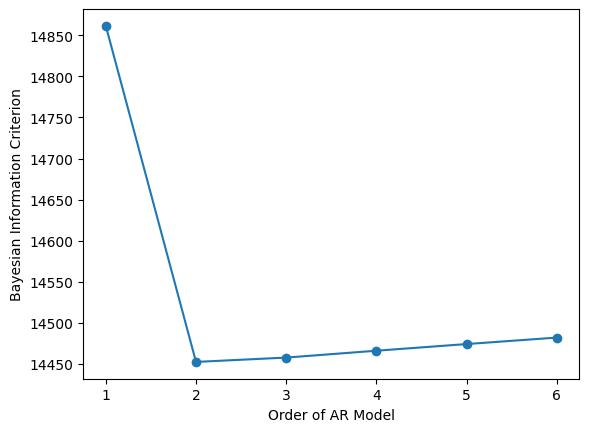

In [21]:
BIC = np.zeros(7)
for p in range(7):
    model = ARIMA(simulated_data_2, order=(p, 0, 0))
    results = model.fit()
    BIC[p] = results.bic

# plot BIC as a function of p
plt.plot(range(1, 7), BIC[1:7], marker="o")
plt.xlabel("Order of AR Model")
plt.ylabel("Bayesian Information Criterion")
plt.show()


## Moving Average Models

_Moving average_ models are similar to autoregressive models, except that the previous values are _errors_ (residuals) instead of previous values:

$X_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}$

where $\mu$ is the mean of the series, $\epsilon_t$ is the error at time $t$, $\theta_1$ is the lag-1 coefficient, $\theta_2$ is the lag-2 coefficient, and so on.

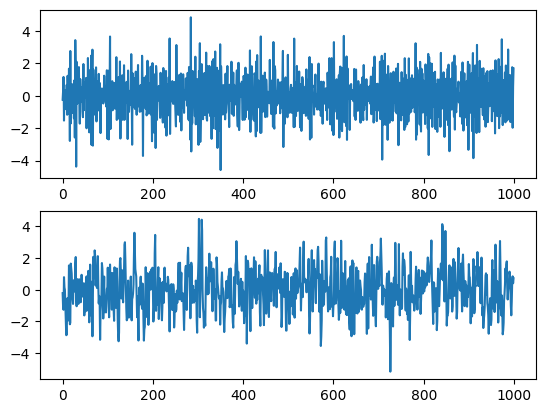

In [22]:
plt.subplot(2, 1, 1)
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

plt.subplot(2, 1, 2)
ar2 = np.array([1])
ma2 = np.array([1, 0.9])
MA_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = MA_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)
plt.show()


## Cointegration Models

_Cointegration_ is a statistical property of time series that measures the extent to which they are stationary when combined.

If two series $P_t$ and $Q_t$ are both random walks, then they are not forecastable. However, if the linear combination $P_t - c Q_t$ is not a random walk, then $P_t$ and $Q_t$ are _cointegrated_.

In [23]:
# add constant (intercept)
eth = sm.add_constant(eth)

# fit OLS regression model
result = sm.OLS(btc, eth).fit()

# extract slope coefficient
b = result.params.iloc[1]

# ADF test
adf = adfuller(btc["Price"] - b * eth["Price"])
print(
    f"The p-value for the ADF test is {adf[1]:0.2f}"
)  # reject null hypothesis (they are stationary)


The p-value for the ADF test is 0.02
